In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model, mixed_precision
import numpy as np
import matplotlib.pyplot as plt

import os

os.chdir('..')

In [2]:
! git clone https://github.com/Jannoshh/simple-sam.git
! git pull
! python sam.py

Cloning into 'simple-sam'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 100 (delta 51), reused 48 (delta 19), pack-reused 0
Receiving objects: 100% (100/100), 111.42 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (51/51), done.
fatal: not a git repository (or any of the parent directories): .git
python3: can't open file 'sam.py': [Errno 2] No such file or directory


In [39]:

import tensorflow as tf


class SAM():
    def __init__(self, base_optimizer, rho=0.1, eps=1e-12):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"
        
        self.rho = rho
        self.eps = eps
        self.base_optimizer = base_optimizer

    def first_step(self, gradients, trainable_vars):
        self.e_ws = []
        grad_norm = tf.linalg.global_norm(gradients)
        ew_multiplier = self.rho / (grad_norm + self.eps)
        for i in range(len(trainable_vars)):
            e_w = tf.math.multiply(gradients[i], ew_multiplier)
            trainable_vars[i].assign_add(e_w)
            self.e_ws.append(e_w)

    def second_step(self, gradients, trainable_variables):
        for i in range(len(trainable_variables)):
            trainable_variables[i].assign_add(-self.e_ws[i])
        # do the actual "sharpness-aware" update
        self.base_optimizer.apply_gradients(zip(gradients, trainable_variables))


# if you want to use model.fit(), override the train_step method of a model with this function, example is mnist_example_keras_fit.
# for customization see https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/
def sam_train_step(self, data, rho=0.1, eps=1e-12):
    # Unpack the data. Its structure depends on your model and
    # on what you pass to `fit()`.
    if len(data) == 3:
        x, y, sample_weight = data
    else:
        sample_weight = None
        x, y = data

    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # first step
    e_ws = []
    grad_norm = tf.linalg.global_norm(gradients)
    ew_multiplier = rho / (grad_norm + eps)
    for i in range(len(trainable_vars)):
        e_w = tf.math.multiply(gradients[i], ew_multiplier)
        trainable_vars[i].assign_add(e_w)
        e_ws.append(e_w)

    with tf.GradientTape() as tape:
        y_pred = self(x, training=True)  # Forward pass
        # Compute the loss value
        # (the loss function is configured in `compile()`)
        loss = self.compiled_loss(y, y_pred, sample_weight=sample_weight, regularization_losses=self.losses)
        
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    for i in range(len(trainable_vars)):
        trainable_vars[i].assign_sub(e_ws[i])
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update the metrics.
    # Metrics are configured in `compile()`.
    self.compiled_metrics.update_state(y, y_pred, sample_weight=sample_weight)

    # Return a dict mapping metric names to current value.
    # Note that it will include the loss (tracked in self.metrics).
    return {m.name: m.result() for m in self.metrics}


In [5]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


# Add a channels dimension
#x_train = x_train[..., tf.newaxis].astype("float32")
#x_test = x_test[..., tf.newaxis].astype("float32")

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))#.shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [7]:
from matplotlib.cbook import flatten


class MyModelSAM(Model):
  def __init__(self,layersize):
    super(MyModelSAM, self).__init__()
    
    self.flatten = Flatten()
    self.d1 = Dense(layersize, activation="relu",kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),bias_constraint=tf.keras.constraints.MinMaxNorm(
min_value=0.0, max_value=0.0, rate=1.0, axis=0))
    self.d2 = Dense(10, dtype='float32', activation = 'softmax')


  def call(self, x):
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)
  
  def train_step(self, data):
    return sam_train_step(self, data)






In [14]:
def trainModel(amount, min_layer ,max_layer, layers, epoch,samplesize, noise):
  a = max_layer - min_layer
  data = np.zeros((7,a))
  w_b = []
  w_a = []
  w_c = []

  '''
  data[0][i] = x-axes of the density function
  data[1][i] = density function
  data[2][i] = the test loss after evaluating the model in iterration i (with i layers) 
  data[3][i] = the test accuracy after evaluating the model in iterration i (with i layers) 
  data[4][i] = epochs needed for reachen train-risk < 0.01 in iterration i (with i layers)
  '''

  for i in range(0,max_layer - min_layer):
    print("I an currently in run ",i, " ===> The model has ", i+ min_layer ,"neurons. ")

    #setting up SAM with i = min_layer neurons in hiddenlayer
    sam_model = MyModelSAM(i + min_layer)
    sam_model.build((None, 28, 28, 1))
    sam_model.compile("adam",
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    print(sam_model.summary())

    #getting the weight-Vectors
    layer_weights_bevor = sam_model.layers[1].get_weights()[0]
    layer_biases_bevor  = sam_model.layers[1].get_weights()[1]


    #train
    runs = 0
    train_loss = 100
    train_acc = 0
    e_per_run = 1
    while (train_loss > 0.01) and runs < epoch:
      history = sam_model.fit(x_train[:samplesize], y_train[:samplesize],e_per_run)
      print(history)
      train_loss_all, train_acc_all = history.history.values()
      train_loss = train_loss_all[e_per_run-1]
      train_acc = train_acc_all[e_per_run-1]
      runs = runs + e_per_run
    
    #ecaluating
    test_loss, test_acc = sam_model.evaluate(x_test, y_test, verbose=1)

    #getting the weight-Vectors
    layer_weights_after = sam_model.layers[1].get_weights()[0]
    layer_biases_after  = sam_model.layers[1].get_weights()[1]

    #weight change
    print("Weightchange: " ,np.shape(abs(layer_weights_bevor) - abs(layer_weights_after)))
    change_weights = abs((layer_weights_bevor) - (layer_weights_after)).flatten() 
    change_biases = abs((layer_biases_bevor) - (layer_biases_after)).flatten()

    average_weights_change = sum(change_weights)/len(change_weights)
    average_biases_change = sum(change_biases)/len(change_biases)
    print(sam_model.summary())

    data[0][i] = train_loss
    data[1][i] = train_acc
    data[2][i] = test_loss
    data[3][i] = test_acc
    data[4][i] = runs
    data[5][i] = average_weights_change
    data[6][i] = average_biases_change

    w_b.append(layer_weights_bevor)
    w_a.append(layer_weights_after)
    w_c.append(change_weights)

  return [w_c,w_b,w_a,data]

##plot the Kurves and epochs needed


I an currently in run  0  ===> The model has  20 neurons. 
Model: "my_model_sam_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        multiple                  0         
                                                                 
 dense_38 (Dense)            multiple                  15700     
                                                                 
 dense_39 (Dense)            multiple                  210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 0s 1ms/step - loss: 1.8882 - accuracy: 0.4380
Weightchange:  (784, 20)
Model: "my_model_sam_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        multiple                  0         
                                                                 
 dense_38 (Dense)            multiple                  15700     
                                                                 
 dense_39 (Dense)            multiple                  210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
None


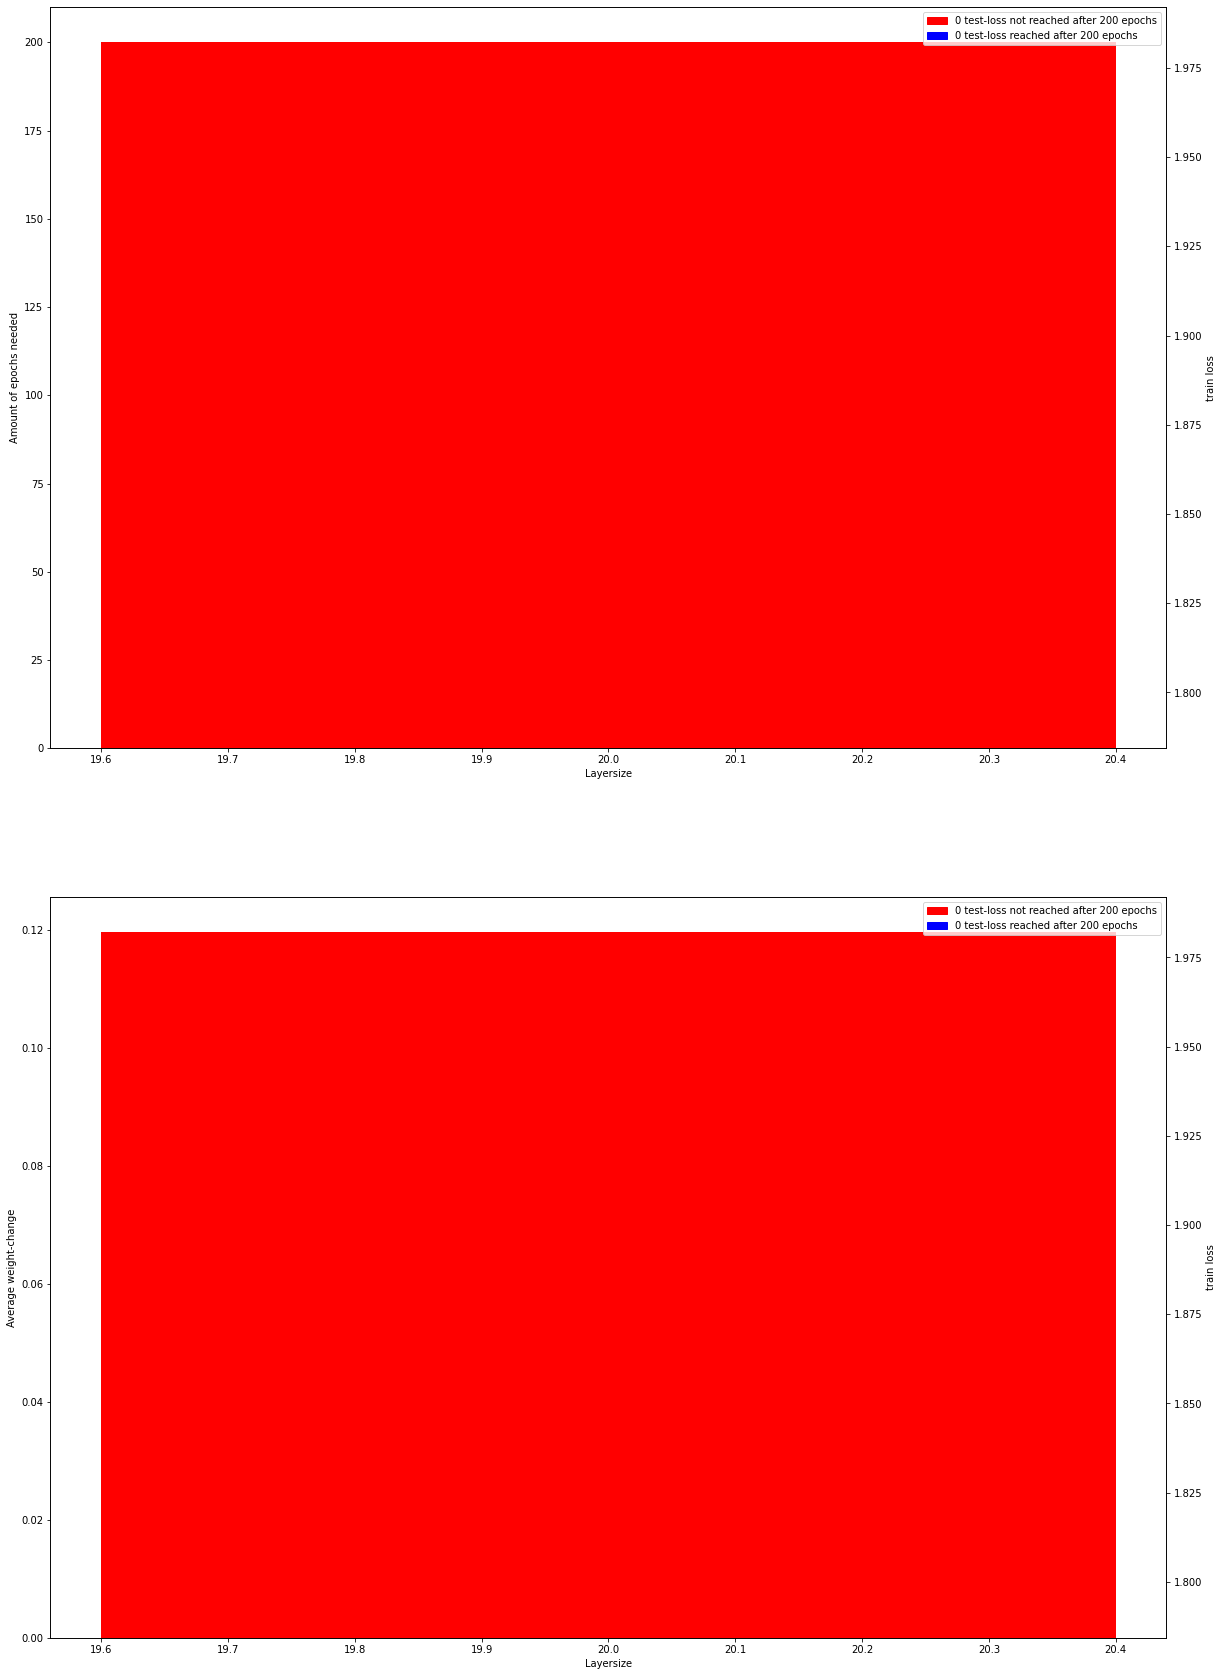

In [40]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

def plot__epochs_needed(max_epochs):
  min_layer = 20
  max_layer = 21
  w_c,w_b,w_a,data = trainModel(1,min_layer,max_layer,1, max_epochs ,5000, 0) 
  data_epochs = data[4]
  colors = ['red' if x == max_epochs else 'blue' for x in data_epochs]
  

  fig, [ax1,ax2] = plt.subplots(2)

  par1 = ax1.twinx()
  par2 = ax2.twinx()

  fig.set_size_inches(20,30)
  ax1.bar(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)), data_epochs, color = colors , width = 0.8)
  ax1.set_xlabel('Layersize')
  ax1.set_ylabel('Amount of epochs needed')
  par1.plot(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)),data[2], color = 'black', label = 'test loss', linewidth= 4.0)
  par1.set_ylabel('train loss')

  ax2.bar(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)), data[5], color = colors , width = 0.8)
  ax2.set_xlabel('Layersize')
  ax2.set_ylabel('Average weight-change')
  par2.plot(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)),data[2], color = 'black', label = 'test loss', linewidth= 4.0)
  par2.set_ylabel('train loss')


  #legend
  import matplotlib.patches as mpatches

  pop_a = mpatches.Patch(color='red', label="0 test-loss not reached after " + str(max_epochs) + " epochs")
  pop_b = mpatches.Patch(color='blue', label="0 test-loss reached after " + str(max_epochs) + " epochs")

  ax1.legend(handles=[pop_a,pop_b])
  ax2.legend(handles=[pop_a,pop_b])
   
  plt.savefig("kurve_with_various_epochs.png")


plot__epochs_needed(200)